In [2]:
import nltk
from nltk.tokenize import WhitespaceTokenizer
from string import punctuation
import re
import string
import random

%matplotlib inline
import os
from lxml import etree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pymorphy2
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.preprocessing import MinMaxScaler

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

E:\programs\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# take twits from csv file

def take_text(fin):
    f = open(fin, 'r', encoding = 'utf-8')
    twi = []
    cont = []
    l = f.readlines()
    for i in l:
        i = i.replace('"\n', '')
        if i[0] == '"':
            lst = i[1:].split('";"')
        else:
            lst = i.split('";"')
        if len(lst) == 12:
            twi.append(lst)
        elif cont == []:
            cont += lst
        elif '\n' in cont[-1] and lst != []:
            c = cont[-1]
            cont = cont[:-1]
            cont.append(c+lst[0])
            cont += lst[1:]
            if len(cont) == 12:
                twi.append(cont)
                cont = []
    f.close()
    
    only_twits = []
    for line in twi:
        only_twits.append(line[3])
    
    return only_twits

In [4]:
twits = take_text('positive.csv')
neg_twits = take_text('negative.csv')

In [5]:
twits = random.sample(twits, len(twits)//10)
neg_twits = random.sample(neg_twits, len(neg_twits)//10)

In [6]:
m = 'ruwikiruscorpora_0_300_20.bin.gz'
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(m, binary=True)

2017-06-15 21:43:26,181 INFO loading projection weights from ruwikiruscorpora_0_300_20.bin.gz
2017-06-15 21:45:36,566 INFO loaded (392339, 300) matrix from ruwikiruscorpora_0_300_20.bin.gz


In [7]:
morph = pymorphy2.MorphAnalyzer()
def normalize_and_pos(word):
    p = morph.parse(word)[0]
    pos = p.tag.POS
    if pos:
        if 'ADJ' in pos:
            pos = 'ADJ'
    else:
        pos = ''
    return '{}_{}'.format(p.normal_form, pos)

2017-06-15 21:45:37,103 INFO Loading dictionaries from E:\programs\Anaconda3\lib\site-packages\pymorphy2_dicts\data
2017-06-15 21:45:38,988 INFO format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [13]:
def spacing(text):
    spaces = re.findall('[^\\w]((?:\\w ){3,}\\w)[ '+string.punctuation+'—–…“”«»'+']',text)
    for elem in spaces:
        text = text.replace(elem,elem.replace(' ',''))
    return text

In [9]:
def normalize(l):
    l = re.sub(r"((https?:\/\/|www)|\w+\.(\w{2-3}))([\w\!#$&-;=\?\-\[\]~]|%[0-9a-fA-F]{2})+", '', l) #убираем ссылки
    l = re.sub(r"(?:@\w+)", '', l)                                        # убираем пользователя
    l = re.sub(r"[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]", '', l)             # убираем email
    l = re.sub(r"(?:I'm at .*? in .*?(?: w/ @[\w])?|\(@ .*?\))", '', l)   # убираем геолокации
    l = l.replace('RT', '')                                               # убираем RT    
    exclude = string.punctuation + '0123456789' + u'—' + u'«»'
    regex = re.compile('[%s]' % re.escape(exclude))
    l = regex.sub(' ', l)
    lower_up = [m.start() for m in re.finditer(r"[a-zа-яё]{1}[A-ZА-ЯЁ]{1}", l)]   # добавляем пробел между lower- и uppercase HiWorld => Hi World 
    for i in reversed(lower_up):
        l = l[:i+1] + ' ' + l[i+1:]
    l = re.sub(u'(\w)\\1{2,}', u'\\1\\1', l)                             # буквы больше двух раз подряд
    l = spacing(l)                                                       # р а з р я д к а
    l = l.lower()                                                        # уменьшаем регистр у всех букв  
    return l

In [19]:
# create dataframe

def without_feat(twits, clas):
    data = []
    for text in twits:
        text_vectors = []
        text_n = normalize(text)
        words = text_n.split()
        for word in words:
            norm_word = normalize_and_pos(word)
            if norm_word in model:
                text_vectors.append(model[norm_word])
        if len(text_vectors) != 0:
            mean_vector = sum(text_vectors) / len(text_vectors)        
            data.append(list(mean_vector))
    df = pd.DataFrame.from_dict({'text':data})
    df['class'] = clas
    return df

In [20]:
df1 = without_feat(twits, 1)
df2 = without_feat(neg_twits, 0)
df = pd.concat([df1, df2])
df = df.sample(frac=1).reset_index(drop=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(list(df['text']), list(df['class']), test_size=0.3)

In [22]:
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

In [23]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    if clf == MultinomialNB(alpha=.01):
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train_norm, y_train)
    t0 = time
    if clf == MultinomialNB(alpha=.01):
        pred = clf.predict(X_test)
    else:
        pred = clf.predict(X_test_norm)
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    if "penalty" in vars(clf):
        return clf_descr+' '+str(clf.penalty), score
    else:
        return clf_descr, score

results1 = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
#        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results1.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results1.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results1.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results1.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results1.append(benchmark(NearestCentroid()))

# Train Logistic Regression
print('=' * 80)
print("Logistic Regression")
results1.append(benchmark(LogisticRegression()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results1.append(benchmark(MultinomialNB(alpha=.01)))
results1.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results1.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())
])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
accuracy:   0.584

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
accuracy:   0.551

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
accuracy:   0.497

Random forest
________________________________________________________

E:\programs\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.578

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.618

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)


E:\programs\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.577

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.550

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.619

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
Near

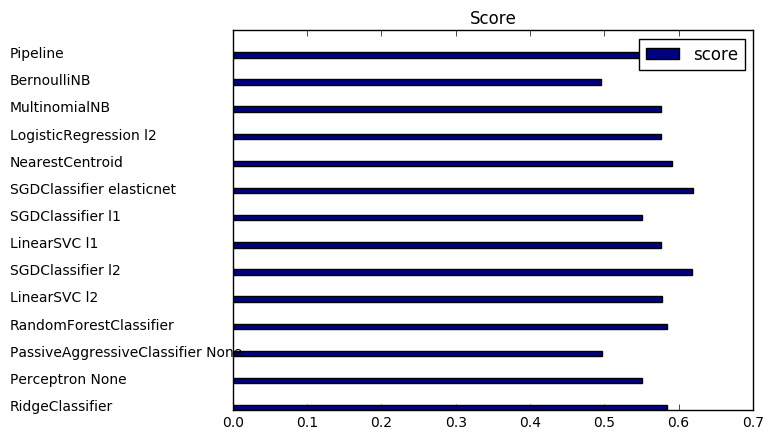

In [24]:
# make some plots

indices = np.arange(len(results1))

results1 = [[x[i] for x in results1] for i in range(2)]

scores = results1[1]
cls_names = results1[0]

plt.figure(figsize=(8, 4))
plt.title("Score")
plt.barh(indices, scores, .2, label="score", color='navy')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=1)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, results1[0]):
    plt.text(-.3, i, c)
plt.show()

In [31]:
# create dataframe with additional features

def with_features(twits, clas):
    data = []
    for text in twits:
        text_vectors = []
        text_n = normalize(text)
        words = text_n.split()
        for word in words:
            norm_word = normalize_and_pos(word)
            if norm_word in model:
                text_vectors.append(model[norm_word])
        if len(text_vectors) != 0:
            mean_vector = sum(text_vectors) / len(text_vectors)        
            formal_features = []
            pos = text.count(')')
            neg = text.count('(')
            formal_features.append(float(pos))
            formal_features.append(float(neg))
            data.append(list(mean_vector)+formal_features)
    df = pd.DataFrame.from_dict({'text':data})
    df['class'] = clas
    return df

In [32]:
data1 = with_features(twits, 1)
data2 = with_features(neg_twits, 0)

In [34]:
data = pd.concat([data1, data2])
data = data.sample(frac=1).reset_index(drop=True)

In [38]:
data.head()

,text,class
0,"[0.00600557, -0.0556959, 0.0679505, -0.0175384...",0
1,"[-0.00553019, -0.010193, 0.00144233, -0.019602...",0
2,"[-0.000713307, -0.0388518, -0.00420037, 0.0644...",1
3,"[0.0211409, -0.00777293, -0.0153508, 0.0322123...",0
4,"[-0.0088839, 0.0479245, 0.0456542, 0.00694215,...",1


In [39]:
X_train, X_test, y_train, y_test = train_test_split(list(data['text']), list(data['class']), test_size=0.3)

In [40]:
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

In [42]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)

    if clf == MultinomialNB(alpha=.01):
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train_norm, y_train)

    if clf == MultinomialNB(alpha=.01):
        pred = clf.predict(X_test)
    else:
        pred = clf.predict(X_test_norm)
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    if "penalty" in vars(clf):
        return clf_descr+' '+str(clf.penalty), score
    else:
        return clf_descr, score

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
#        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train Logistic Regression
print('=' * 80)
print("Logistic Regression")
results.append(benchmark(LogisticRegression()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())
])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
accuracy:   0.849

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
accuracy:   0.929

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
accuracy:   0.791

Random forest
________________________________________________________

E:\programs\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.925

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.903

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)


E:\programs\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.969

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.931

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.896

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
Near

E:\programs\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


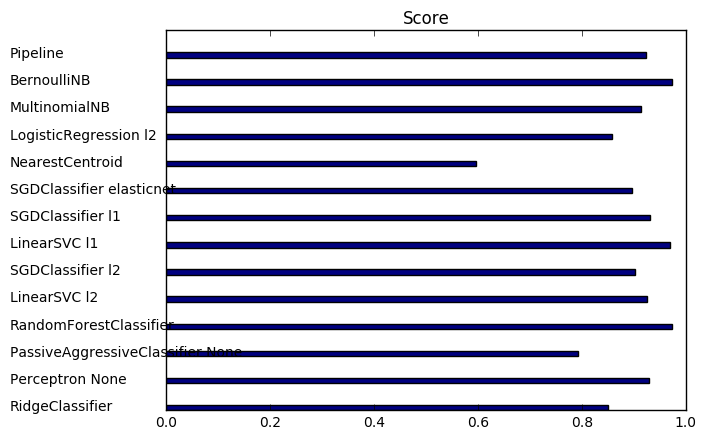

In [43]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(2)]

scores = results[1]
cls_names = results[0]

plt.figure(figsize=(8, 4))
plt.title("Score")
plt.barh(indices, scores, .2, color='navy')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=1)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, results[0]):
    plt.text(-.3, i, c)
plt.show()

In [ ]:
import json 
from twitter import Twitter, OAuth

ACCESS_TOKEN = ''
ACCESS_SECRET = ''
CONSUMER_KEY = ''
CONSUMER_SECRET = ''

oauth = OAuth(ACCESS_TOKEN, ACCESS_SECRET, CONSUMER_KEY, CONSUMER_SECRET)

twitter = Twitter(auth=oauth)

user = ''

results = twitter.statuses.user_timeline(screen_name=user, count=200)

twits_data = pd.DataFrame(columns=['time', 'text'])

for i in range(len(results)):
    twits_data.loc[i] = [results[i]['created_at'], results[i]['text']]

In [45]:
# create dataframe with additional features

def add_vector(df):
    new_df = pd.DataFrame(columns = ['time', 'text'])
    data = []
    for i in range(len(df['text'])):
        text_vectors = []
        text_n = normalize(df['text'][i])
        words = text_n.split()
        for word in words:
            norm_word = normalize_and_pos(word)
            if norm_word in model:
                text_vectors.append(model[norm_word])
        if len(text_vectors) != 0:
            mean_vector = sum(text_vectors) / len(text_vectors)        
            formal_features = []
            pos = df['text'][i].count(')')
            neg = df['text'][i].count('(')
            formal_features.append(float(pos))
            formal_features.append(float(neg))
            data.append(list(mean_vector)+formal_features)
            new_df.loc[len(new_df)] = df.loc[i]
    new_df['vector'] = data
    return new_df

In [46]:
twits_data = add_vector(twits_data)

In [47]:
X_tw = list(twits_data['vector'])
X_twits = min_max_scaler.fit_transform(X_tw)

In [48]:
from sklearn.ensemble import VotingClassifier

In [49]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
#    t0 = time()
    if clf == MultinomialNB(alpha=.01):
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train_norm, y_train)
#    t0 = time
    if clf == MultinomialNB(alpha=.01):
        pred = clf.predict(X_tw)
    else:
        pred = clf.predict(X_twits)
    return pred


In [34]:
clf1 = RidgeClassifier(tol=1e-2, solver="lsqr")
clf2 = Perceptron(n_iter=50)
clf3 = PassiveAggressiveClassifier(n_iter=50)
#        (KNeighborsClassifier(n_neighbors=10), "kNN"),
clf4 = RandomForestClassifier(n_estimators=100)
clf5 = LinearSVC(loss='l2', penalty='l1', dual=False, tol=1e-3)
clf6 = SGDClassifier(alpha=.0001, n_iter=50, penalty='l1')
clf7 = LinearSVC(loss='l2', penalty='l2', dual=False, tol=1e-3)
clf8 = SGDClassifier(alpha=.0001, n_iter=50, penalty='l2')
clf9 = SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet")
clf10 = NearestCentroid()
clf11 = LogisticRegression()
clf12 = MultinomialNB(alpha=.01)
clf13 = BernoulliNB(alpha=.01)
clf14 = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())])

In [35]:
eclf = VotingClassifier(estimators=[('rfk', clf6), ('log', clf5),  ('pip', clf13)], voting='soft').fit(X_train_norm, y_train)
pred = eclf.predict(X_twits)

# это была неудачная попытка использования ансамбля классификаторов

E:\programs\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [62]:
pred = benchmark(SGDClassifier(alpha=.0001, n_iter=50, penalty='l2'))

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [63]:
twits_data['class'] = pred

In [64]:
from collections import defaultdict

marks = defaultdict(list)

time_ord = []

for i in range(len(twits_data)):
    t = re.findall('[A-Za-z]{2,3} [A-Za-z]{2,3} \d{,2}', twits_data['time'][i])[0]
    marks[t].append(twits_data['class'][i])
    if t not in time_ord:
        time_ord.append(t)

In [65]:
points = []

day_mark = defaultdict(int)
time_ord = time_ord[::-1]
for i in time_ord:
    m = marks[i]
    day_mark[i] = (m.count(1)-m.count(0))/len(m)
    points.append((m.count(1)-m.count(0))/len(m))

In [66]:
d_m = []

for i in time_ord:
    d_m.append(i[4:])

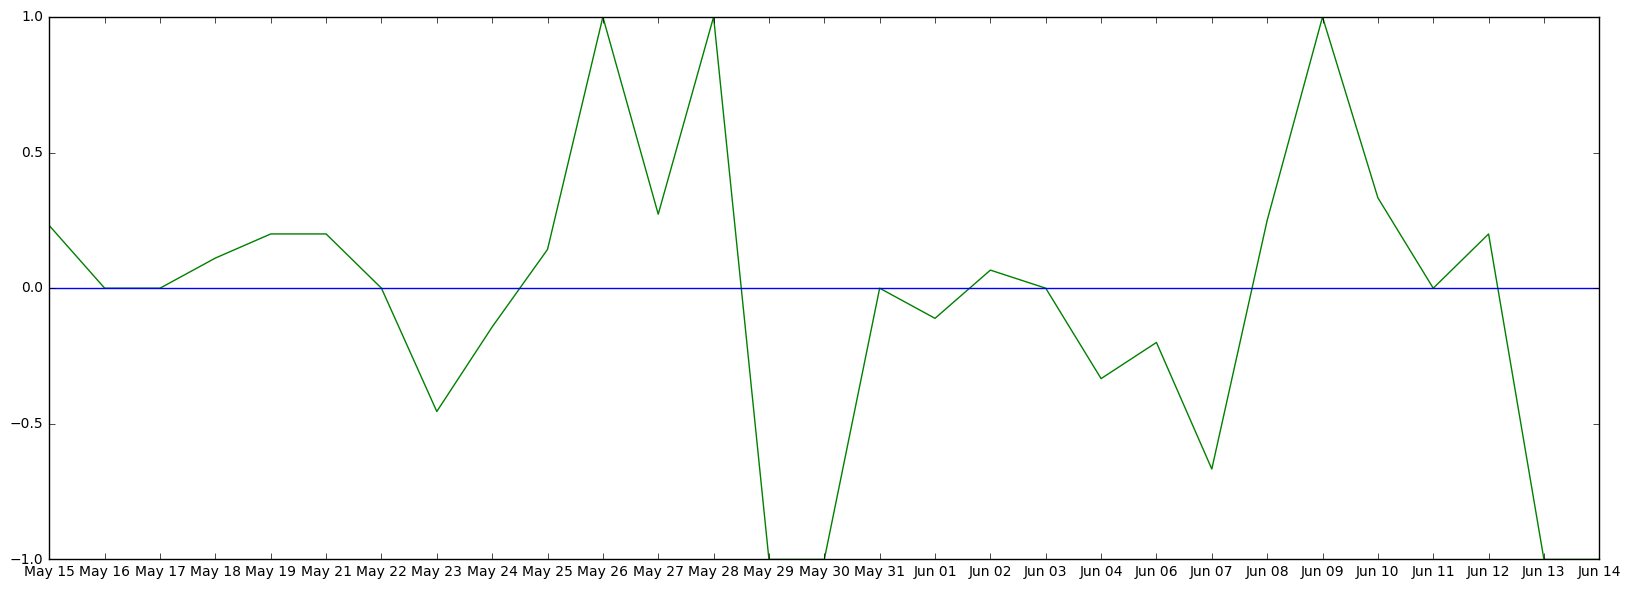

In [67]:
import pylab


pylab.figure(figsize=(20, 7))
x = range(len(time_ord))
ind = []
[ind.append(i) for i in x]
pylab.xticks(x, d_m)
pylab.plot(x, points, "g")
zero = [0 for i in x]
pylab.plot(x, zero)

pylab.show()

In [68]:
twits_data.head()

,time,text,vector,class
0,Wed Jun 14 06:52:23 +0000 2017,@creacion_D МОСКВА. ЛЕТО,"[-0.0226735, -0.00354648, -0.0347097, 0.039337...",0
1,Tue Jun 13 14:26:35 +0000 2017,@melanoya Зависит от. Но у меня всегда пару дн...,"[-0.0141913, 0.00660214, -0.0125005, 0.0249399...",0
2,Mon Jun 12 17:25:00 +0000 2017,"@asya_fipl Так это точно она? Я уж думала, что...","[0.0101522, -0.0317261, 0.0286605, -0.0048266,...",0
3,Mon Jun 12 17:21:53 +0000 2017,"@asya_fipl Нужна вера, что все получится :)","[0.0279572, -0.0506765, -0.017352, 0.0752001, ...",1
4,Mon Jun 12 12:22:38 +0000 2017,@creacion_D Чтобы жизнь была веселее! Чтобы бы...,"[0.0379646, 0.0233801, -0.101888, -0.00819619,...",0


In [70]:
# по дням недели

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

df_week = pd.DataFrame(index=days, columns=['week1'])
df_week['week1'] = np.nan
w = 1
week = 'week1'

for i in time_ord:
    for d in days:
        if d in i:
            if np.isnan(df_week[week][d]):
                df_week[week][d] = day_mark[i]
            else:
                w += 1
                week = 'week'+str(w)
                df_week[week] = np.nan

In [71]:
df_week

,week1,week2,week3,week4
Mon,0.230769,-1.000000,NaN,0.200000
Tue,0.000000,-0.454545,-0.200000,-1.000000
Wed,0.000000,-0.142857,0.000000,-1.000000
Thu,0.111111,0.142857,-0.111111,0.250000
Fri,0.200000,1.000000,0.066667,1.000000
Sat,NaN,0.272727,0.000000,0.333333
Sun,0.200000,1.000000,-0.333333,0.000000


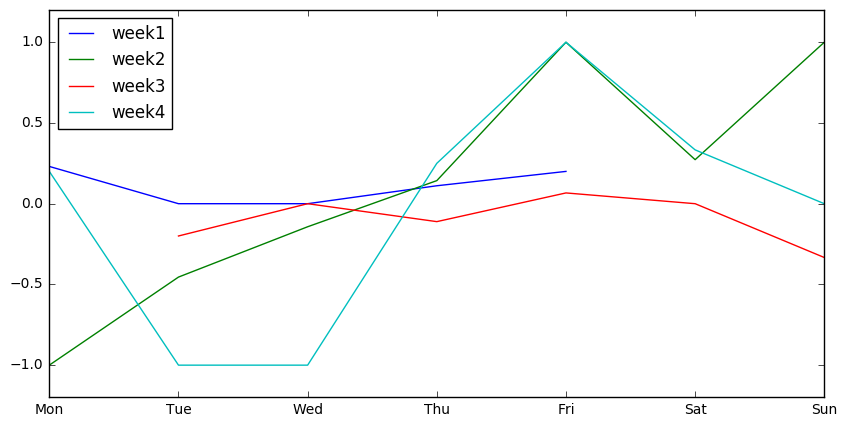

In [72]:
f = plt.figure(figsize=(10, 5)) 
df_week.plot(ax=f.gca(), ylim=[-1.2, 1.2]) 